In [14]:
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt

# Introduction

This miniapp solves the *linear Boltzmann equation* (LBE), which is an integro-differential equation that has a myriad of applications in various scientific and engineering fields. It describes the behaviour of particles as they are travel through a background medium. In one spatial dimension, the LBE is:
$$
\underbrace{\mu\frac{d}{dx}\psi(x,\mu)}_{\text{Self-advection}} + \underbrace{\sigma_t \psi(x,\mu)}_{\text{Interaction}} = \underbrace{\frac{\sigma_s}{2}\int_{-1}^{1}\psi(x,\mu)\,d\mu}_{\text{Scattering}} + \underbrace{\frac{q_{ext}(x)}{2}}_{\text{Source}}\text{,}
$$
where $\mu\in[-1, 1]$ is the x-axis direction cosine (direction of particle travel dotted with $\hat{e}_{x}$), $x\in [-L,L]$ is the 1D independent spatial variable , $\sigma_t$ is the total interaction coefficient, $\sigma_s$ is the scattering interaction coefficient ($\sigma_s \leq \sigma_t$), and $\psi(x,\mu)$ is the angular particle flux. The LBE is best described as an infinite number of linear advection equations in the spatial variable coupled together by the integral over all values of $\mu$. The boundary conditions we will consider in this miniapp are the *no-reentrent* boundary conditions:
$$
\psi(x,\mu) = 0,\,\,\,\, \mu < 0\text{ and }x = L
$$
$$
\psi(x,\mu) = 0,\,\,\,\, \mu > 0\text{ and }x = -L
$$
For reasons that will become apparent later, we will make the following substitution:
$$
\phi_{0}(x) = \int_{-1}^{1}\psi(x,\mu)\,d\mu\text{,}
$$
$$
\mu\frac{d}{dx}\psi(x,\mu) + \sigma_t \psi(x,\mu) = \frac{\sigma_s}{2}\phi_{0}(x) +\frac{q_{ext}(x)}{2}\text{,}
$$
where $\phi_{0}(x)$ is the 0'th *Legendre angular moment* of the flux; the quantity of interest when solving the LBE. There are several methods for solving the LBE, each of them hinge on different techniques for discretizing the angular dependence of $\psi(x,\mu)$. Once $\mu$ is discretized any class of methods normally used for hyperbolic conservation laws can be applied to the spatial variable. 

## A Model Problem

The problem this notebook solves is the Reed benchmark problem, which is a numerical test of $x-\mu$ discretization schemes for the LBE in 1D. The problem geometry consists of the following regions with a total domain length of $L = 8$:

| Region | Location | $\sigma_t$ | $\sigma_s$ | $q$ |
| --- | :-: | :-: | :-: | :-: |
| 1 | $-2 < x < 2$ | 50.0 | 0.0 | 50.0 |
| 2 | $2 \leq x < 3$, $-3 < x \leq -2$ | 5.0 | 0.0 | 0.0 |
| 3 | $3 \leq x < 5$, $-5 < x \leq -3$ | 0.0 | 0.0 | 0.0 |
| 4 | $5 \leq x < 6$, $-6 < x \leq -5$ | 1.0 | 0.9 | 1.0 |
| 5 | $6 \leq x < 8$, $-8 < x \leq -6$ | 1.0 | 0.9 | 0.0 |

There are no analytic solutions to this problem, but there are well-agreed upon numerical solutions which have been computed with the Monte Carlo method.

We define the material properties and spatial grid with a series of helper functions.

In [15]:
# Some helper functions to define material properties. 
# - x is a numpy array of cell centroids
def source(x):
    q = np.zeros_like(x)
    q[np.where((x > -2.0) & (x < 2.0))[0]] = 50.0
    q[np.where(((x > 5.0) & (x < 6.0)) | ((x > -6.0) & (x < -5.0)))[0]] = 1.0
    return q
def sigma_t(x):
    st = np.zeros_like(x)
    st[np.where((x > -2.0) & (x < 2.0))[0]] = 50.0
    st[np.where(((x > 2.0) & (x < 3.0)) | ((x > -3.0) & (x < -2.0)))[0]] = 5.0
    st[np.where(((x > 5.0) & (x < 8.0)) | ((x > -8.0) & (x < -5.0)))[0]] = 1.0
    return st
def sigma_s(x):
    ss = np.zeros_like(x)
    ss[np.where(((x > 5.0) & (x < 8.0)) | ((x > -8.0) & (x < -5.0)))[0]] = 0.9
    return ss

# A function which builds the benchmark problem for a different number of grid points.
# - I is the number of grid points
def make_reed_benchmark(I):
    # Problem length.
    L = 8.0
    
    x_grid = np.linspace(-L, L, I)
    q = 0.5 * source(x_grid)
    st = sigma_t(x_grid)
    ss = sigma_s(x_grid)
    return x_grid, q, st, ss

# The SN Method with Richardson Iteration

The first (and most common) of these approaches is the discrete ordinates ($S_N$) method, a collocation method on $[-1,1]$ for $\mu$. A quadrature rule is picked which converts the integral over all direction cosines into a summation over a finite number of angular directions (also known as discrete ordinates, hence the name), resulting in the following LBE and auxilliary equation:
$$
\mu_{n}\frac{d}{dx}\psi(x,\mu_{n}) + \sigma_t \psi(x,\mu_{n}) = \frac{\sigma_s}{2}\phi_{0}(x) +\frac{q_{ext}(x)}{2}\text{,}
$$
and
$$
\phi_{0}(x) = \sum_{n=0}^{N}w_{n}\psi(x,\mu_n)\text{.}
$$
This converts the continuum problem in angle into a discrete problem, which is fantastic, but there are still some difficulties involved with this approach as all of the directions are coupled together in $\mu$ (resulting in a very large matrix system once the spatial variable is discretized). To solve this problem, *Richardson iteration* is used to decouple the angular variables from eachother by lagging the scattering term:
$$
\mu_{n}\frac{d}{dx}\psi^{\ell+1}(x,\mu_{n}) + \sigma_t \psi^{\ell+1}(x,\mu_{n}) = \frac{\sigma_s}{2}\phi^{\ell}_{0}(x) +\frac{q_{ext}(x)}{2}
$$
with
$$
\phi^{\ell}_{0}(x) = \sum_{n=0}^{N}w_{n}\psi^{\ell}(x,\mu_n)\text{.}
$$
with $\psi^{0}(x,\mu_n) = 0$. For the rest of this notebook we denote the discrete ordiante fluxe as $\psi^{\ell}_{n}(x) = \psi^{\ell}_{n}(x,\mu_n)$ and collapse the external and scattering source into a single term to further compact the notation:
$$
q^{\ell}(x) = \frac{\sigma_s}{2}\phi^{\ell}_{0}(x) +\frac{q_{ext}(x)}{2}
$$
which yields
$$
\mu_{n}\frac{d}{dx}\psi^{\ell+1}_{n}(x) + \sigma_t \psi^{\ell+1}_{n}(x) = q^{\ell}(x)
$$

## Improved Iteration Procedure

While this is a good start, it's often impractical to implement Richardson iteration in this form for solving the LBE as it requires storage of all angular fluxes at a ggiven iteration. A better approach is to first solve for the *uncollided flux* ($\psi^{1}_{n}(x)$) using the following equation:
$$
\mu_{n}\frac{d}{dx}\psi^{1}_{n}(x) + \sigma_t \psi^{1}_{n}(x) = q_{ext}(x)
$$
Then, the $\ell$'th scattered angular flux can be computed with:
$$
\mu_{n}\frac{d}{dx}\psi^{\ell}_{n}(x) + \sigma_t \psi^{\ell}_{n}(x) = \frac{\sigma_s}{2}\phi^{\ell - 1}_{0}(x)
$$
The total angular flux then becomes:
$$
\psi_{n}(x) = \sum_{\ell = 1}^{\infty}\psi^{\ell}_{n}(x)
$$
and the 0'th angular moment is:
$$
\phi_{0}(x) = \sum_{\ell = 1}^{\infty}\phi^{\ell}_{0}(x)
$$
This form of Richardson iteration allows for the gradual accumulation of the 0'th angular moment of the flux without needing to store the angular flux, which saves memory! This approach can be shown to be equivalent to standard Richardson iteration with a proof by induction. As we cannot implement an infinite series on digital computers, we truncate the iterative prodecure by checking if the 0'th angular moment is near-stationary in the $L_{2}$ grid norm:
$$
e_{tol} = \frac{\sum_{i = 0}^{I}\phi^{\ell}_{0,i}}{\sum_{j = 0}^{\ell}\sum_{i = 0}^{I}\phi^{j}_{0,i}}
$$
which is implemented in the function below.

In [16]:
# A function which computes the Richardson iteration tolerance for convergence.
# - legendre_0_tot is the sum of all 0'th angular moment iterates
# - legendre_0_par is the 0'th angular moment at the current iteration
def richardson_tol(legendre_0_tot, legendre_0_par):
    return np.sum(legendre_0_par) / np.sum(legendre_0_tot)

# Spatial Discretization

With the angular variable discretized, the final step is to discretize the spatial variable. This can be done by partitioning the domain into a grid with $I$ cells each with a length $h_x = 2L/(I - 1)$. The center of each cell is $x_i$, and the edges of the cell are located at $x_{i\pm1/2}$. We make the approximation that $\sigma_t$, $\sigma_s$, and $q$ are piecewise-constant within cells which only change at the cell interfaces. Integrating the 1D S$_N$ over a single cell yields:
$$
\mu_{n}\Big(\psi^{\ell+1}_{n}(x_{i+1/2}) - \psi^{\ell+1}_{n}(x_{i-1/2})\Big) + h_x\sigma_t \psi^{\ell+1}_{n,i} = h_x q^{\ell}_{i}
$$
where $\psi^{\ell}_{n,i}$ is the cell-averaged angular flux and $\phi^{\ell}_{0,i}$ is the cell-averaged source:
$$
\psi^{\ell}_{n,i} = \frac{1}{h_{x}}\int_{x_{i-1/2}}^{x_{i+1/2}}\psi^{\ell}_{n}(x)\,dx
$$
$$
q^{\ell}_{i} = \frac{1}{h_{x}}\int_{x_{i-1/2}}^{x_{i+1/2}}q^{\ell}(x)\,dx
$$
The cell-balance equation presented above is exact, however it represents a system of equations of length $I$ with $3I$ unknowns (two for the boundary fluxes and one for the cell-centered flux). To close the system we need another auxiliary equation; the easiest to implement is *diamond differencing* with upwinding, where the cell-average flux is equal to the mean of the interface angular fluxes:
$$
\psi^{\ell}_{n,i} = \frac{\psi^{\ell}_{n,i+1/2}+\psi^{\ell}_{n,i-1/2}}{2}
$$
which is identical to a Crank Nicolson method in space. We can use this closure to eliminate one of the interface angular fluxes; the one that's picked to eliminate is the "downwind" flux. For the case where $\mu_{n} > 0$, we eliminate $\psi^{\ell}_{n,i+1/2}$ which results in: 
$$
\psi^{\ell}_{n,i} = \Bigg(1 + \frac{\sigma_{t,i}h_{x}}{2|\mu_{n}|}\Bigg)^{-1}\Bigg(\psi^{\ell}_{n,i-1/2} + \frac{q^{\ell-1}_{i}h_{x}}{2|\mu_{n}|}\Bigg)
$$
with 
$$
\psi^{\ell}_{n,i+1/2} = 2\psi^{\ell}_{n,i} - \psi^{\ell}_{n,i-1/2}
$$
For the case where $\mu_{n} < 0$, we eliminate $\psi^{\ell}_{n,i-1/2}$ which results in: 
$$
\psi^{\ell}_{n,i} = \Bigg(1 + \frac{\sigma_{t,i}h_{x}}{2|\mu_{n}|}\Bigg)^{-1}\Bigg(\psi^{\ell}_{n,i+1/2} + \frac{q^{\ell-1}_{i}h_{x}}{2|\mu_{n}|}\Bigg)
$$
with
$$
\psi^{\ell}_{n,i-1/2} = 2\psi^{\ell}_{n,i} - \psi^{\ell}_{n,i+1/2}
$$

The functions below implement these equations for $\psi^{\ell}_{n,i}$ and $\psi^{\ell}_{n,i\pm 1/2}$ (in a direction-agnostic manner).

In [17]:
# Helper function to compute the cell-centered angular flux
# - flux_uw is the upwind angular flux
# - mu_n is the x-axis direction cosine
# - q is the source in the current cell
# - st is the total interaction coefficient in the current cell
# - hx is the grid spacing
def cell_center_af(flux_uw, mu_n, q, st, hx):
    num = flux_uw + 0.5 * q * hx / np.abs(mu_n)
    den = 1.0 + 0.5 * st * hx / np.abs(mu_n)
    return num / den

# Helper function to compute the downwind angular flux
# - center is the cell-centered angular flux
# - upwind is the upwind angular flux
def downwind_af(center, upwind):
    return 2.0 * center - upwind

It looks like we still have a system of $2I$ equations with $3I$ unknowns, however this is not the case! We know the boundary angular fluxes for both $\mu < 0$ and $\mu > $; they should be zero at $x = -L$ / $x = L$! This admits a very efficient solution algorithm for the $S_{N}$ method where one starts at the appropriate boundary for a given $\mu_n$ and marches through the cells. On each cell, the cell-centered angular flux is computed given the "upwind" flux. This is followed by the calculation of the cell's "downwind" flux, which is then used to compute the next cell's cell-centered flux (and so on). This is equivalent to saying that the discretization matrix formed by this spatial discretization is block lower/upper triangular, and so it can be solved with back substitution! We implement this grid walking scheme (known as a *transport sweep* in LBE literature) with the following two functions.

In [18]:
# A function which walks the grid from left to right, and accumulates the 0'th angular moment for a particular direction
# - q is a numpy array of total source (scattering + external) at the cell centers
# - st is a numpy array of total interaction coefficients at the cell centers
# - mu_n is the x-axis direction cosine
# - hx is the grid spacing
def sweep_l_to_r(q, st, mu_n, hx):
    af_n = np.zeros_like(q)
    # Apply boundary condition.
    flux_uw = 0.0
    # For all grid points.
    for idx in range(len(q)):
        # Calculate the angular flux.
        af_n[idx] = cell_center_af(flux_uw, mu_n, q[idx], st[idx], hx)
        # Calculate the downwind interface flux.
        flux_uw = downwind_af(af_n[idx], flux_uw)
    # At the end, return the angular flux
    return af_n

# A function which walks the grid from right to left, and accumulates the 0'th angular moment for a particular direction
# - q is a numpy array of total source (scattering + external) at the cell centers
# - st is a numpy array of total interaction coefficients at the cell centers
# - mu_n is the x-axis direction cosine
# - hx is the grid spacing
def sweep_r_to_l(q, st, mu_n, hx):
    af_n = np.zeros_like(q)
    # Apply boundary condition.
    flux_uw = 0.0
    # For all grid points.
    for idx in reversed(range(len(q))):
        # Calculate the angular flux.
        af_n[idx] = cell_center_af(flux_uw, mu_n, q[idx], st[idx], hx)
        # Calculate the downwind interface flux.
        flux_uw = downwind_af(af_n[idx], flux_uw)
    # At the end, return the angular flux
    return af_n

Finally, we can implement the full LBE solver. The solution procedure starts by setting up the problem and angular quadrature rule. We chose to use a Gauss-Legendre quadrature as it can exactly integrate polynomials in angle (which matters when you care about higher order angular moments of the flux). Afterwards, we start the the outer iterative procedure to converge the scattering source. On each iteration we loop over all directions in the angular quadrature set and walk the grid (left to right for $\mu > 0$, right to left for $\mu < 0$) to compute the angular flux for that direction. This is then accumulated with the appropriate quadrature weight to compute the 0'th flux moment for that iteration. After the "sweeps" over the grid are complete, we add the iteration's flux moment to the sum over all iterations, check for convergence, and repeat if necessary.

In [19]:
# Solve for the distribution of the 0'th angular moment of the flux with the SN method
def solve_sn(x_grid, q, st, ss, N):
    # SN diamond-differencing discretization parameters
    hx = x_grid[1] - x_grid[0]

    # Angular quadrature roots / weights
    q_rule = np.polynomial.legendre.leggauss(N)

    # Storage for the 0'th angular moment of the flux
    legendre_0_tot = np.zeros_like(x_grid)
    legendre_0_par = np.zeros_like(x_grid)

    # Modified Richardson iteration: sweep the flux until it converges!
    num_itr = 0
    while num_itr < 1000:
        # For all negative values of mu: sweep right to left
        for n in range(0, int(N / 2)):
            legendre_0_par += q_rule[1][n] * sweep_r_to_l(q, st, q_rule[0][n], hx)

        # For all positive values of mu: sweep left to right
        for n in range(int(N/2), N):
            legendre_0_par += q_rule[1][n] * sweep_l_to_r(q, st, q_rule[0][n], hx)

        # Accumulate the 0'th moment of the angular flux after each Richardson iteration
        legendre_0_tot += legendre_0_par
        
        # Update the scattering source
        q = 0.5 * ss * legendre_0_par

        # Check convergence. 1e-8 is extremely tight, most LBE solvers use something between 1e-3 and 1e-5
        if richardson_tol(legendre_0_tot, legendre_0_par) < 1e-8:
            break
        
        # Zero out the partial 0'th flux moment
        legendre_0_par = np.zeros_like(x_grid)
        num_itr += 1
        
    return legendre_0_tot

# Results

Now that we've implemented the full LBE solver, we can test it on the Reed problem! We start with a very coarse spatial discretization of 20 grid points and vary the number of directions in the quadrature set from 2 to 32. We can see that the coarse spatial discretization results in jagged peaks where we expect smooth attenuation of the radiation field. Additionally, as the number of directions increases we see that the 0'th angular moment starts to asymptote towards a constant value in the region which contains a non-zero scattering coefficient.

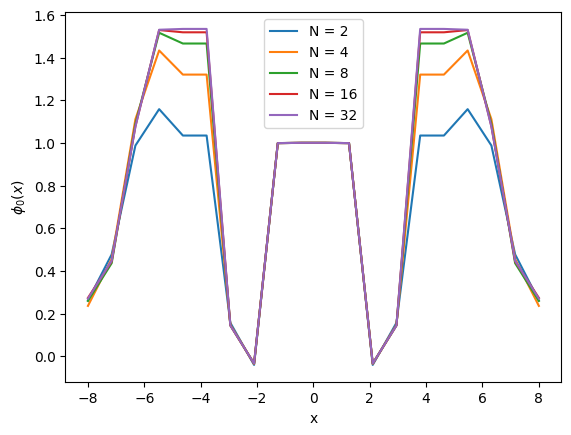

In [20]:
# Solve the problem with 20 grid points and increasing values of mu.
[x_grid, q, st, ss] = make_reed_benchmark(20)
plt.plot(x_grid, solve_sn(x_grid, q, st, ss, 2), label = 'N = 2')
plt.plot(x_grid, solve_sn(x_grid, q, st, ss, 4), label = 'N = 4')
plt.plot(x_grid, solve_sn(x_grid, q, st, ss, 8), label = 'N = 8')
plt.plot(x_grid, solve_sn(x_grid, q, st, ss, 16), label = 'N = 16')
plt.plot(x_grid, solve_sn(x_grid, q, st, ss, 32), label = 'N = 32')
plt.xlabel('x')
plt.ylabel('$\phi_{0}(x)$')
plt.legend()
plt.savefig('refinement_0.png')
plt.show()
plt.close()

Increasing the number of grid points to 40, we start to see some of the more defining features of the benchmark. This includes the troughs that occur after the highly attenuating region ($-2 < x < 2$), the peaks caused by the combination of the external source and the scattering source ($5 \leq x < 6$ and $-6 < x \leq -5$), and the plateau caused by the lack of interaction coefficients ($3 \leq x < 5$, $-5 < x \leq -3$). However, we can start to see some oscillations in the highly attenuating region near the center of the problem which is caused by the diamond-difference closure relationship. We can also see that increasing the number of angular directions appears to result in improved radiation redistribution from scattering while better representing the particle source. At this point, the maximum value of the 0'th angular moment (2.5) overshoots the true maximum (2.0), which is caused by a space-angle discretization that is unable to account for the jump discontinuity in the scattering source.

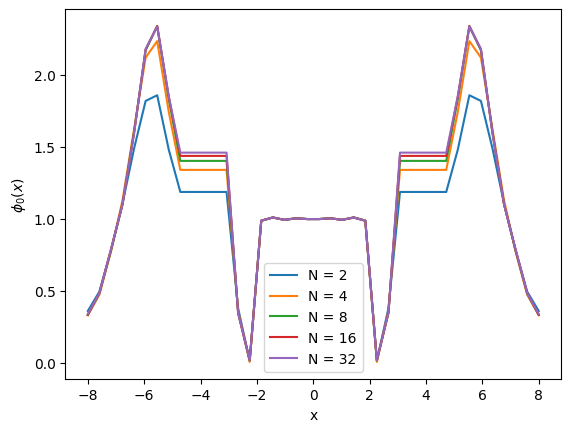

In [21]:
# Solve the problem with 40 grid points and increasing values of mu.
[x_grid, q, st, ss] = make_reed_benchmark(40)
plt.plot(x_grid, solve_sn(x_grid, q, st, ss, 2), label = 'N = 2')
plt.plot(x_grid, solve_sn(x_grid, q, st, ss, 4), label = 'N = 4')
plt.plot(x_grid, solve_sn(x_grid, q, st, ss, 8), label = 'N = 8')
plt.plot(x_grid, solve_sn(x_grid, q, st, ss, 16), label = 'N = 16')
plt.plot(x_grid, solve_sn(x_grid, q, st, ss, 32), label = 'N = 32')
plt.xlabel('x')
plt.ylabel('$\phi_{0}(x)$')
plt.legend()
plt.savefig('refinement_1.png')
plt.show()
plt.close()

Moving to 80 grid points, we can see that the spurrious oscillations increase in frequency in the center of the problem. These are particularily severe near the strong jump discontinuity, but this medium-fidelity spatial discretization is unable to prevent the propogation of the Gibbs phenomena. We can also see that the solution begins to converge on the correct peaks (2) in the scattering region with an external source, although the distribution itself is jagged.

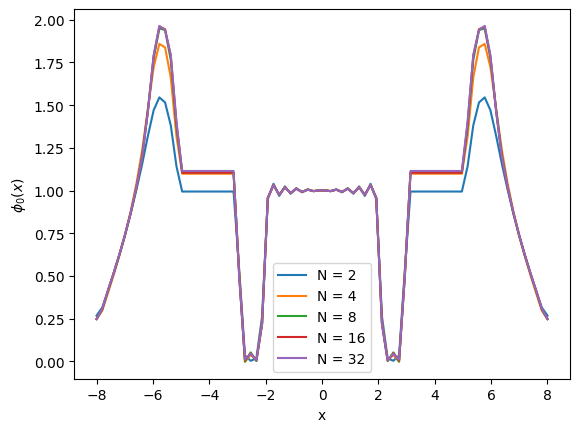

In [22]:
# Solve the problem with 80 grid points and increasing values of mu.
[x_grid, q, st, ss] = make_reed_benchmark(80)
plt.plot(x_grid, solve_sn(x_grid, q, st, ss, 2), label = 'N = 2')
plt.plot(x_grid, solve_sn(x_grid, q, st, ss, 4), label = 'N = 4')
plt.plot(x_grid, solve_sn(x_grid, q, st, ss, 8), label = 'N = 8')
plt.plot(x_grid, solve_sn(x_grid, q, st, ss, 16), label = 'N = 16')
plt.plot(x_grid, solve_sn(x_grid, q, st, ss, 32), label = 'N = 32')
plt.xlabel('x')
plt.ylabel('$\phi_{0}(x)$')
plt.legend()
plt.savefig('refinement_2.png')
plt.show()
plt.close()

At 160 and 320 grid points, we see that the distribution has converged to the reference solution aside from the oscillations discussed previously. Additional grid points only serve to increase the frequency of the oscillations at the interface.

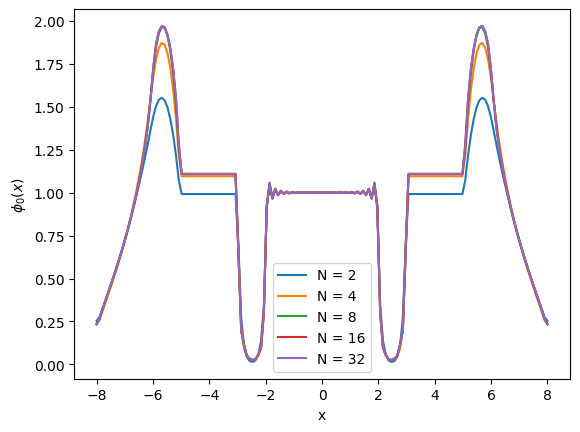

In [23]:
# Solve the problem with 160 grid points and increasing values of mu.
[x_grid, q, st, ss] = make_reed_benchmark(160)
plt.plot(x_grid, solve_sn(x_grid, q, st, ss, 2), label = 'N = 2')
plt.plot(x_grid, solve_sn(x_grid, q, st, ss, 4), label = 'N = 4')
plt.plot(x_grid, solve_sn(x_grid, q, st, ss, 8), label = 'N = 8')
plt.plot(x_grid, solve_sn(x_grid, q, st, ss, 16), label = 'N = 16')
plt.plot(x_grid, solve_sn(x_grid, q, st, ss, 32), label = 'N = 32')
plt.xlabel('x')
plt.ylabel('$\phi_{0}(x)$')
plt.legend()
plt.savefig('refinement_3.png')
plt.show()
plt.close()

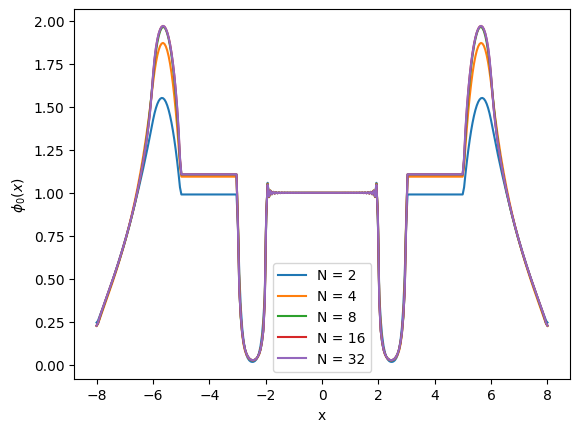

In [24]:
# Solve the problem with 320 grid points and increasing values of mu.
[x_grid, q, st, ss] = make_reed_benchmark(320)
plt.plot(x_grid, solve_sn(x_grid, q, st, ss, 2), label = 'N = 2')
plt.plot(x_grid, solve_sn(x_grid, q, st, ss, 4), label = 'N = 4')
plt.plot(x_grid, solve_sn(x_grid, q, st, ss, 8), label = 'N = 8')
plt.plot(x_grid, solve_sn(x_grid, q, st, ss, 16), label = 'N = 16')
plt.plot(x_grid, solve_sn(x_grid, q, st, ss, 32), label = 'N = 32')
plt.xlabel('x')
plt.ylabel('$\phi_{0}(x)$')
plt.legend()
plt.savefig('refinement_4.png')
plt.show()
plt.close()